In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns   
import warnings
import plotly.graph_objects as go


# Suppress df assignment warning
pd.options.mode.chained_assignment = None  

# Define file paths
ais_tracks_path = '../data/tracks_ais.csv'
radar_tracks_path = '../data/tracks_radar.csv'
radar_detections_path = '../data/detections_radar.csv'
tagged_detections_path = '../data/detections_tagged.csv'
tracks_tagged_path = '../data/tracks_tagged.csv'

ais_tracks = pd.read_csv(ais_tracks_path)
radar_tracks = pd.read_csv(radar_tracks_path)
radar_detections = pd.read_csv(radar_detections_path)
tagged_detections = pd.read_csv(tagged_detections_path)
tracks_tagged = pd.read_csv(tracks_tagged_path)

del ais_tracks_path, radar_tracks_path, radar_detections_path, tagged_detections_path, tracks_tagged_path


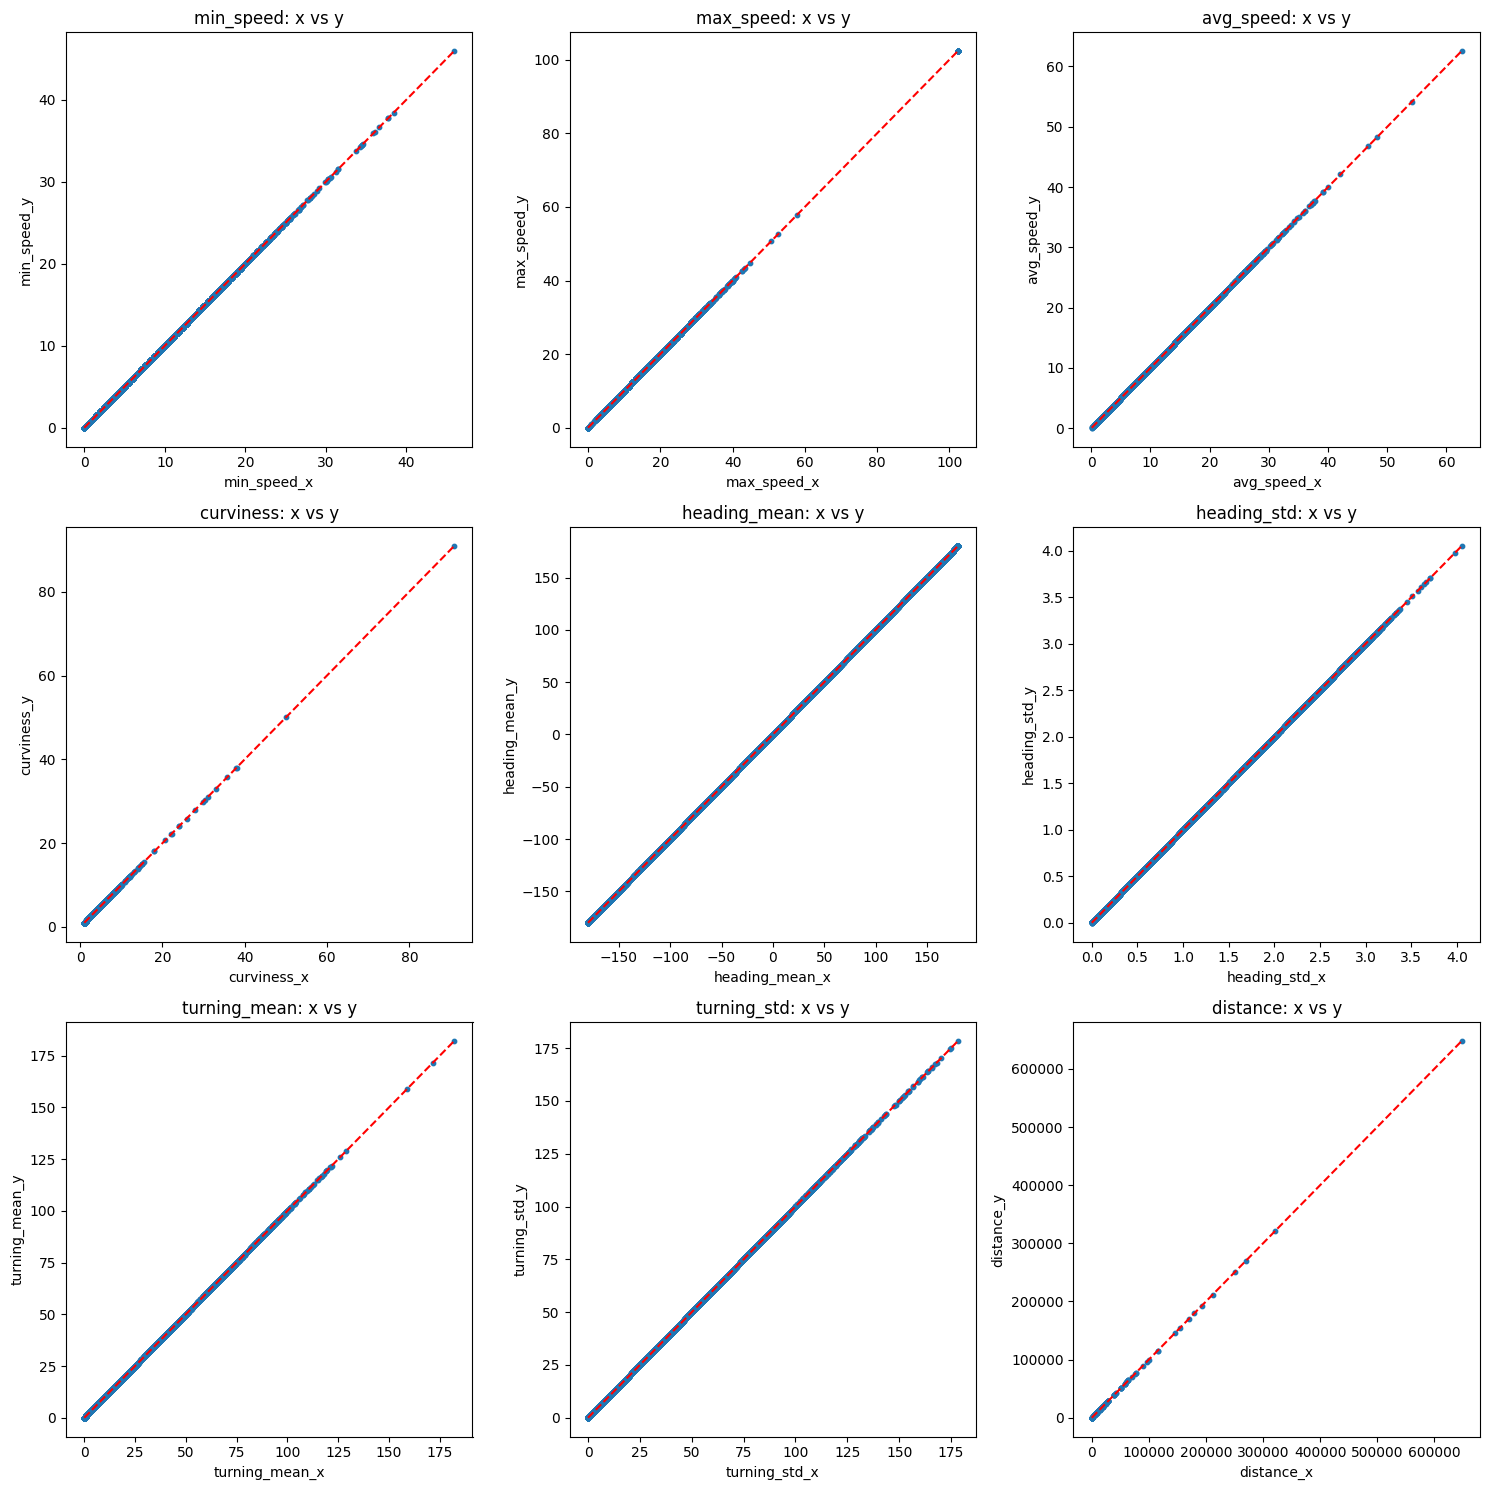

In [53]:
import matplotlib.pyplot as plt

# List of base column names to compare
columns = [
    'min_speed', 'max_speed', 'avg_speed', 'curviness',
    'heading_mean', 'heading_std', 'turning_mean', 'turning_std', 'distance'
]

# Create subplots: 3 plots per row
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(columns):
    ax = axes[i]
    x = reference_merged[f"{col}_x"]
    y = reference_merged[f"{col}_y"]
    ax.scatter(x, y, s=10)
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')  # y = x line
    ax.set_title(f"{col}: x vs y")
    ax.set_xlabel(f"{col}_x")
    ax.set_ylabel(f"{col}_y")

# Hide any unused subplots (in case there are fewer than 9)
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [10]:
class SumStats:
    columns = ['id_detect', 'id_track', 'id_site', 'id_m2', 'source', 'speed','course', 'assoc_str', 'assoc_id', 'confidence', 'cdate', 'ctime',
        'longitude', 'latitude']    

    def __init__(self):
        pass

    @staticmethod
    def compute_track_features(group, KMPS_TO_KNOTS=1943.84449):
        """Helper function to compute track features for a single group"""
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            group['datetime'] = pd.to_datetime(group['cdate'] + ' ' + group['ctime'])

        group = group.sort_values(by='datetime').copy()
        group['latitude_prev'] = group['latitude'].shift(1)
        group['longitude_prev'] = group['longitude'].shift(1)
        group['time_prev'] = group['datetime'].shift(1)
        group['speed_prev'] = group['speed'].shift(1)
        group['course_prev'] = group['course'].shift(1)
        
        # Calculate differences between consecutive detections
        group['distance_diff'] = SumStats._haversine_distance(
            group['latitude_prev'], group['longitude_prev'],
            group['latitude'], group['longitude']
        )
        group['time_diff'] = (group['datetime'] - group['time_prev']).dt.total_seconds()
        group['speed_diff'] = abs(group['speed'] - group['speed_prev'])
        group['heading_diff'] = abs(group['course'] - group['course_prev'])
        
        # Calculate instantaneous speed
        group['instant_speed'] = group['distance_diff'] / group['time_diff'] * KMPS_TO_KNOTS
        return group

    @classmethod
    def compute_track_stats(cls, group, KMPS_TO_KNOTS = 1943.84449):
        """
        Takes df of detections for a single track and computes summary statistics.
        For a full detection dataset, use df.groupby('id_track').apply(SumStats.compute_track_stats).reset_index()
        """
        if not set(cls.columns).issubset(group.columns):
            print(f"Missing columns for id_track: {group.name}")
        
        # Use compute_track_features to calculate necessary features
        group = cls.compute_track_features(group, KMPS_TO_KNOTS)

        # Calculate the summary statistics based on the features
        start_lat = group['latitude'].iloc[0]
        start_lon = group['longitude'].iloc[0]
        end_lat = group['latitude'].iloc[-1]
        end_lon = group['longitude'].iloc[-1]

        total_distance = group['distance_diff'].sum()
        total_time = (group['datetime'].iloc[-1] - group['datetime'].iloc[0]).total_seconds()

        if total_time <= 0:
            print(f'Problematic track with 0 total time: id_track ={group["id_track"].iloc[0]}')

        avg_speed = group['speed'].mean()
        max_speed = group['speed'].max()
        min_speed = group['speed'].min()
        
        curviness = total_distance / cls._haversine_distance(start_lat, start_lon, end_lat, end_lon)
        heading_mean = cls._circular_mean(group['course'])
        heading_std = cls._circular_std(group['course'])
        turning_mean = cls._circular_mean(group['heading_diff'])
        turning_std = cls._circular_std(group['heading_diff'])
        
        return pd.Series({
            'assoc_id': group['assoc_id'].iloc[0],
            'avg_speed': avg_speed,
            'max_speed': max_speed,
            'min_speed': min_speed,
            'total_distance': total_distance,
            'curviness': curviness,
            'heading_mean': heading_mean,
            'heading_std': heading_std,
            'turning_mean': turning_mean,
            'turning_std': turning_std
        })


    @staticmethod
    def _haversine_distance(lat1, lon1, lat2, lon2, r = 6371):
        """
        Calculate the distance between two points on the Earth's surface
        using the Haversine formula.

        Args:
            lat1 (float): Latitude of the first point
            lon1 (float): Longitude of the first point
            lat2 (float): Latitude of the second point
            lon2 (float): Longitude of the second point
            r (float): Radius of the Earth in kilometers
        """
        delta_phi = np.radians(lat2 - lat1)
        delta_lambda = np.radians(lon2 - lon1)
        a = np.sin(delta_phi / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(delta_lambda / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return r * c
    
    @staticmethod
    def _circular_mean(angles):
        """
        Calculate the circular mean of a list of angles.
        Args:
            angles(pd series): angles in degress
        Returns:
            float: circular mean of the angles in degrees
        """
        angles = angles * np.pi / 180
        x = np.cos(angles)
        y = np.sin(angles)
        return np.arctan2(np.sum(y), np.sum(x)) * 180 / np.pi

    @staticmethod
    def _circular_std(angles):
        """
        Calculate the circular standard deviation of a list of angles
        Args:
            angles(pd series): angles in degress
        Returns:
            float: circular std of the angles in degrees
        """
        angles = angles * np.pi / 180
        x = np.cos(angles).sum()
        y = np.sin(angles).sum()
        x /= len(angles)
        y /= len(angles)
        R = np.sqrt(x**2 + y**2)
        std = np.sqrt(-2 * np.log(R)) * 180 / np.pi
        return std


In [26]:
import plotly.graph_objects as go


class DebugTrackPlotter:
    """
    Interactive Plotter for a single vessel track with hover and summary stats.
    Init Args:
        current_track: radar_detections corresponding to a single id_track
        ais_tracks: reference ais tracks
    """

    def __init__(self, current_track, ais_tracks):
        self.current_track = current_track
        self.ais_tracks = ais_tracks

    def plot_track(self):
        assert len(self.current_track['id_track'].unique()) == 1, "track_data must be associated with 1 track"
        num_detections = self.current_track.shape[0]
        current_assoc_id = self.current_track['assoc_id'].iloc[0]
        reference = self.ais_tracks[self.ais_tracks['id_track'] == current_assoc_id]

        # Compute per-point and summary stats
        group = SumStats.compute_track_features(self.current_track.copy())  # new helper below
        summary = SumStats.compute_track_stats(group)
        track_id = group['id_track'].iloc[0]

        # Format the title text
        summary_text = f"""
        <b>Track ID:</b> {track_id}<br>
        <b>Num Detections:</b>{num_detections}<br>
        <b>Vessel Type:<b> {reference['type_m2'].iloc[0]}<br><br>

        <b>Manual:</b><br>
        <b>Avg Speed:</b> {summary['avg_speed']:.2f} kn<br>
        <b>Max Speed:</b> {summary['max_speed']:.2f} kn<br>
        <b>Min Speed:</b> {summary['min_speed']:.2f} kn<br> 
        <b>Heading Mean:</b> {summary['heading_mean']:.2f}°<br>
        <b>Heading Std:</b> {summary['heading_std']:.2f}°<br>
        <b>Turning Mean:</b> {summary['turning_mean']:.2f}°<br>
        <b>Turning Std:</b> {summary['turning_std']:.2f}°<br><br>

        <b>AIS:</b><br>
        <b>Avg Speed:</b> {reference['avg_speed'].iloc[0]:.2f} kn<br>
        <b>Max Speed:</b> {reference['max_speed'].iloc[0]:.2f} kn<br>
        <b>Min Speed:</b> {reference['min_speed'].iloc[0]:.2f} kn<br>
        <b>Heading Mean:</b> {reference['heading_mean'].iloc[0]:.2f}°<br>
        <b>Heading Std:</b> {reference['heading_std'].iloc[0]:.2f}°<br>
        <b>Turning Mean:</b> {reference['turning_mean'].iloc[0]:.2f}°<br>
        <b>Turning Std:</b> {reference['turning_std'].iloc[0]:.2f}°
        """

        # Create hover text
        group['hover_text'] = (
            'Course: ' + group['course'].astype(str) +
            '<br>Speed: ' + group['speed'].astype(str) +
            '<br>Instant Speed (knots): ' + group['instant_speed'].round(2).astype(str) +
            '<br>Time Diff (s): ' + group['time_diff'].round(1).astype(str) +
            '<br>Heading Diff (°): ' + group['heading_diff'].round(2).astype(str)
        )

        fig = go.Figure()

        # Trajectory
        fig.add_trace(go.Scattergeo(
            lon=group['longitude'],
            lat=group['latitude'],
            mode='markers+lines',
            marker=dict(size=5, color='blue'),
            line=dict(width=1),
            text=group['hover_text'],
            hoverinfo='text',
            name='Trajectory'
        ))

        # Start point
        fig.add_trace(go.Scattergeo(
            lon=[group['longitude'].iloc[0]],
            lat=[group['latitude'].iloc[0]],
            mode='markers',
            marker=dict(size=10, color='green', symbol='triangle-up'),
            name='Start'
        ))

        # End point
        fig.add_trace(go.Scattergeo(
            lon=[group['longitude'].iloc[-1]],
            lat=[group['latitude'].iloc[-1]],
            mode='markers',
            marker=dict(size=10, color='red', symbol='triangle-down'),
            name='End'
        ))

        # Compute bounding box for automatic zoom
        min_lat, max_lat = group['latitude'].min(), group['latitude'].max()
        min_lon, max_lon = group['longitude'].min(), group['longitude'].max()
        center_lat = (min_lat + max_lat) / 2
        center_lon = (min_lon + max_lon) / 2

        # Estimate appropriate zoom/scale
        lat_range = max_lat - min_lat
        lon_range = max_lon - min_lon
        zoom_scale = max(lat_range, lon_range)
        zoom_scale = max(zoom_scale, 0.1)  # Avoid too tight zoom

        fig.update_layout(
            title=dict(text=summary_text, x=0.01, xanchor='left', yanchor='top',
                       font = dict(size = 12)),
            geo=dict(
                showland=True,
                landcolor='rgb(243, 243, 243)',
                countrycolor='rgb(204, 204, 204)',
                projection_type='equirectangular',
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                resolution=50,
                center=dict(lat=center_lat, lon=center_lon),
                lataxis=dict(range=[min_lat - 0.05, max_lat + 0.05]),
                lonaxis=dict(range=[min_lon - 0.05, max_lon + 0.05]),
            ),
            margin={"r":0, "t":100, "l":0, "b":0}
        )
        fig.show()

In [156]:
class SumStats2:
    columns = ['id_detect', 'id_track', 'id_site', 'id_m2', 'source', 'speed','course', 'assoc_str', 'assoc_id', 'confidence', 'cdate', 'ctime',
        'longitude', 'latitude']    

    def __init__(self):
        pass

    @staticmethod
    def compute_track_features(group, KMPS_TO_KNOTS=1943.84449):
        """Helper function to compute track features for a single group"""
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            group['datetime'] = pd.to_datetime(group['cdate'] + ' ' + group['ctime'])

        group = group.sort_values(by='datetime').copy()
        group['latitude_prev'] = group['latitude'].shift(1)
        group['longitude_prev'] = group['longitude'].shift(1)
        group['time_prev'] = group['datetime'].shift(1)
        group['speed_prev'] = group['speed'].shift(1)
        group['course_prev'] = group['course'].shift(1)
        
        # Calculate differences between consecutive detections
        group['distance_diff'] = SumStats._haversine_distance(
            group['latitude_prev'], group['longitude_prev'],
            group['latitude'], group['longitude']
        )
        group['time_diff'] = (group['datetime'] - group['time_prev']).dt.total_seconds()
        group['speed_diff'] = abs(group['speed'] - group['speed_prev'])
        group['heading_diff'] = abs(group['course'] - group['course_prev'])

        group['instant_speed'] = group['distance_diff'] / group['time_diff']
        group['turning_rate'] = group['heading_diff'] / group['time_diff']
        
        group['instant_speed_prev'] = group['instant_speed'].shift(1)
        group['instant_speed_diff'] = group['instant_speed'] - group['instant_speed_prev']
        group['instant_accel'] = group['instant_speed_diff'] / group['time_diff']

        
        return group

    @classmethod
    def compute_track_stats(cls, group, KMPS_TO_KNOTS = 1943.84449):
        """
        Takes df of detections for a single track and computes summary statistics.
        For a full detection dataset, use df.groupby('id_track').apply(SumStats.compute_track_stats).reset_index()
        """
        if not set(cls.columns).issubset(group.columns):
            print(f"Missing columns for id_track: {group.name}")
            raise ValueError
        
        # Use compute_track_features to calculate necessary features
        group = cls.compute_track_features(group, KMPS_TO_KNOTS)

        start_lat = group['latitude'].iloc[0]
        start_lon = group['longitude'].iloc[0]
        end_lat = group['latitude'].iloc[-1]
        end_lon = group['longitude'].iloc[-1]
        start_time = group['datetime'].iloc[0]
        end_time = group['datetime'].iloc[-1]
        total_distance = group['distance_diff'].sum()
        total_time = (group['datetime'].iloc[-1] - group['datetime'].iloc[0]).total_seconds()

        if total_time <= 0:
            print(f'Problematic track with 0 total time: id_track ={group["id_track"].iloc[0]}')

        # Simple heuristics to mark as disruptions
        if group['instant_speed'].max() >= 150:
            disrupted = 1
        else:
            disrupted = 0
        
        #Speed
        median_speed = group['instant_speed'].median()
        p95_speed = group['instant_speed'].quantile(0.95)
        p5_speed = group['instant_speed'].quantile(0.05)
        speed_std = group['instant_speed'].std()
        #acceleration
        p95_accel = group['instant_accel'].quantile(0.95)
        p5_accel = group['instant_accel'].quantile(0.05)
        median_accel = group['instant_accel'].median()
        accel_std = group['instant_accel'].std()
        
        #heading & turning
        heading_mean = cls._circular_mean(group['course'])
        heading_std = cls._circular_std(group['course'])
        p95_turning_rate = group['turning_rate'].quantile(0.95)
        p5_turning_rate = group['turning_rate'].quantile(0.05)
        median_turning_rate = group['turning_rate'].median()
        turning_rate_std = cls._circular_std(group['turning_rate'])

        #curviness
        curviness = total_distance / cls._haversine_distance(start_lat, start_lon, end_lat, end_lon)

        #mean area covered
        group['lat_travelled'] = abs(group['latitude'] - start_lat)
        group['lon_travelled'] = abs(group['longitude'] - start_lon)
        group['time_elapsed'] = (group['datetime'] - start_time).dt.total_seconds()
        group['area_covered'] = group['lat_travelled'] * group['lon_travelled'] / group['time_elapsed'] #normalized by time elapsed

        p95_area_covered = group['area_covered'].quantile(0.95)
        p5_area_covered = group['area_covered'].quantile(0.05)
        median_area_covered = group['area_covered'].median()
        area_covered_std = group['area_covered'].std()  

        group['distance_from_origin'] = cls._haversine_distance(start_lat, start_lon, group['latitude'], group['longitude'])
        distance_o = group['distance_from_origin'].max()

        # features_subset = [
#     'median_speed',
#     'speed_std', 'p95_accel', 'median_accel',
#     'heading_mean_y', 'heading_std_y', 'p95_turning_rate',
#     'median_turning_rate',
#     'p95_area_covered', 'curviness_y', 'distance_o_y']

        return pd.Series({
            'assoc_id': group['assoc_id'].iloc[0],
            'median_speed': median_speed,
            # 'p95_speed': p95_speed,
            # 'p5_speed': p5_speed,
            'speed_std': speed_std,
            'p95_accel': p95_accel,
            # 'p5_accel': p5_accel,
            'median_accel': median_accel,
            # 'accel_std': accel_std,
            'heading_mean': heading_mean,
            'heading_std': heading_std,
            'p95_turning_rate': p95_turning_rate,
            # 'p5_turning_rate': p5_turning_rate,
            'median_turning_rate': median_turning_rate,
            # 'turning_rate_std': turning_rate_std,
            'p95_area_covered': p95_area_covered,
            # 'p5_area_covered': p5_area_covered,
            # 'median_area_covered': median_area_covered,
            # 'area_covered_std': area_covered_std,
            'curviness': curviness,
            'disrupted': disrupted,
            'distance_o': distance_o    
        })

    @staticmethod
    def _haversine_distance(lat1, lon1, lat2, lon2, r = 6371):
        """
        Calculate the distance between two points on the Earth's surface
        using the Haversine formula.

        Args:
            lat1 (float): Latitude of the first point
            lon1 (float): Longitude of the first point
            lat2 (float): Latitude of the second point
            lon2 (float): Longitude of the second point
            r (float): Radius of the Earth in kilometers
        """
        delta_phi = np.radians(lat2 - lat1)
        delta_lambda = np.radians(lon2 - lon1)
        a = np.sin(delta_phi / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(delta_lambda / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return r * c
    
    @staticmethod
    def _circular_mean(angles):
        """
        Calculate the circular mean of a list of angles.
        Args:
            angles(pd series): angles in degress
        Returns:
            float: circular mean of the angles in degrees
        """
        angles = angles * np.pi / 180
        x = np.cos(angles)
        y = np.sin(angles)
        return np.arctan2(np.sum(y), np.sum(x)) * 180 / np.pi

    @staticmethod
    def _circular_std(angles):
        """
        Calculate the circular standard deviation of a list of angles
        Args:
            angles(pd series): angles in degress
        Returns:
            float: circular std of the angles in degrees
        """
        angles = angles * np.pi / 180
        x = np.cos(angles).sum()
        y = np.sin(angles).sum()
        x /= len(angles)
        y /= len(angles)
        R = np.sqrt(x**2 + y**2)
        std = np.sqrt(-2 * np.log(R)) * 180 / np.pi
        return std


In [100]:
#Select only radar detections w/ matching records
common_ids = set(radar_tracks['id_track']) & set(radar_detections['assoc_id'])
print(len(common_ids))
common_radar_detections = radar_detections[radar_detections['assoc_id'].isin(common_ids)]

15345


In [157]:
summary_df = common_radar_detections.groupby('id_track').apply(SumStats2.compute_track_stats).reset_index()

/var/folders/jm/bv3tgs257hx9tx764_p9xq0w0000gn/T/ipykernel_76175/2017586160.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



### Examine SumStats

In [117]:
comparison = pd.merge(ais_tracks, summary_df, left_on='id_track', right_on='assoc_id', how='inner')
comparison.rename(columns = {'id_track_y': 'id_track', 'assoc_id_y':'assoc_id'}, inplace = True)
comparison.drop(columns=['id_track_x', 'assoc_id_x'], inplace=True)


In [80]:
comparison[comparison['turning_std_x'] >= 100]['id_track'].sample(10)


KeyError: 'turning_std_x'

In [75]:
debug_track = radar_detections[radar_detections['id_track'] ==35052361]
debug_plotter = DebugTrackPlotter(debug_track, ais_tracks)
debug_plotter.plot_track()


### Plotting to Check Consistency

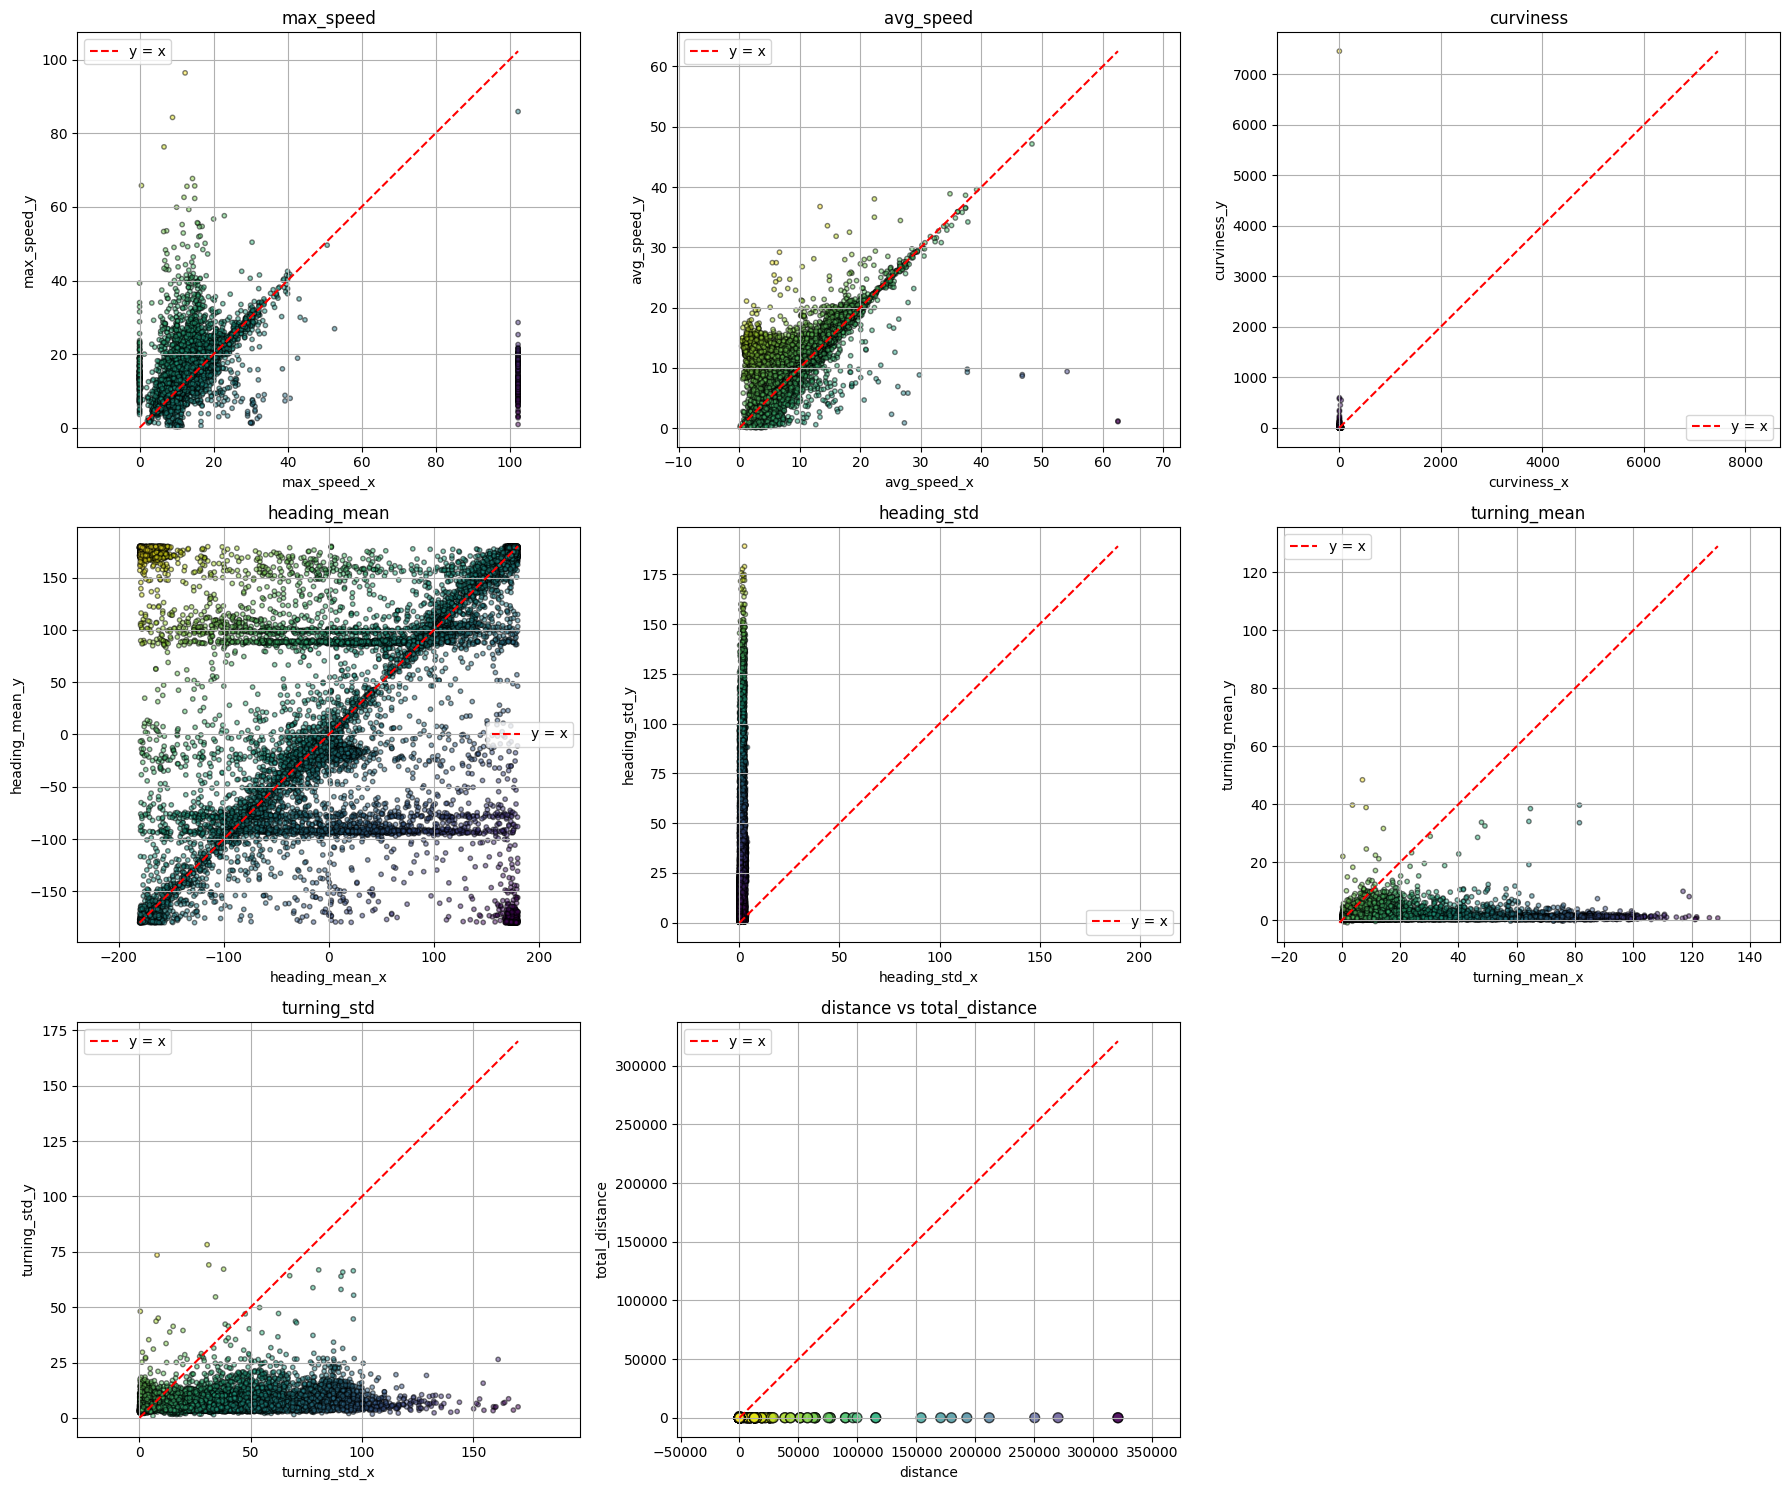

In [121]:
import matplotlib.pyplot as plt
import numpy as np

variables = [
    'max_speed', 'avg_speed', 'curviness',
    'heading_mean', 'heading_std',
    'turning_mean', 'turning_std'
]

n_cols = 3
n_rows = (len(variables) + 1 + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 5 * n_rows))

for i, var in enumerate(variables):
    x = comparison[f'{var}_x']
    y = comparison[f'{var}_y']
    color = y - x

    plt.subplot(n_rows, n_cols, i + 1)
    scatter = plt.scatter(
        x, y,
        c=color, cmap='viridis', s=10, alpha=0.5, edgecolor='k'
    )

    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

    plt.xlabel(f'{var}_x')
    plt.ylabel(f'{var}_y')
    plt.title(var)
    plt.axis('equal')
    plt.grid(True)
    plt.legend()

# Special case: distance vs total_distance
x = comparison['distance']
y = comparison['total_distance']
color = y - x

plt.subplot(n_rows, n_cols, len(variables) + 1)
scatter = plt.scatter(
    x, y,
    c=color, cmap='viridis', s=50, alpha=0.7, edgecolor='k'
)

min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel('distance')
plt.ylabel('total_distance')
plt.title('distance vs total_distance')
plt.axis('equal')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Type Classification

In [158]:
#Use my version of track sumamry stats
merged = pd.merge(ais_tracks, summary_df, left_on='id_track', right_on='assoc_id', how='inner')


In [159]:
tagged_detections_track_stats = tagged_detections.groupby('id_track').apply(SumStats.compute_track_stats).reset_index()

#Only drops ~1% possibly duplicate tracks
tracks_tagged_no_assoc = tracks_tagged[tracks_tagged['assoc_id'].isna()]

#Extract human labels as 'type_m2' for tagged_tracks
#currently filter out lobster and fishing(non-lobster) boats
tracks_tagged_no_assoc['type_m2'] = 'N/A'
# Create mask for fishing boats (including fishing_c and fishing_r)
fishing_mask = (
    tracks_tagged_no_assoc['notes'].str.contains('fishing', case=False, na=False) | 
    tracks_tagged_no_assoc['notes'].str.contains('lobster', case=False, na=False) | 
    (tracks_tagged_no_assoc['fishing_c'] == 1) | 
    (tracks_tagged_no_assoc['fishing_r'] == 1)
)

tracks_tagged_no_assoc.loc[fishing_mask, 'type_m2'] = 'fishing_boat'

#~90% of the tagged tracks are missing meaningful labels though, drop them
tracks_tagged_no_assoc = tracks_tagged_no_assoc[tracks_tagged_no_assoc['type_m2'] != 'N/A']

tagged_detections_summary = pd.merge(tracks_tagged_no_assoc,tagged_detections_track_stats, on='id_track', how='inner')
tagged_detections_summary.columns


/var/folders/jm/bv3tgs257hx9tx764_p9xq0w0000gn/T/ipykernel_76175/2385371728.py:63: RuntimeWarning:

invalid value encountered in scalar divide

/var/folders/jm/bv3tgs257hx9tx764_p9xq0w0000gn/T/ipykernel_76175/2385371728.py:63: RuntimeWarning:

invalid value encountered in scalar divide

/var/folders/jm/bv3tgs257hx9tx764_p9xq0w0000gn/T/ipykernel_76175/1779583052.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Index(['id_track', 'id_site', 'id_m2', 'source', 'duration', 'alarm',
       'min_speed_x', 'max_speed_x', 'avg_speed_x', 'curviness_x',
       'heading_mean_x', 'heading_std_x', 'turning_mean_x', 'turning_std_x',
       'duration_z', 'distance', 'distance_o', 'assoc_str', 'assoc_id_x',
       'tagged', 'has_photos', 'confidence', 'detections', 'sdate', 'stime',
       'ldate', 'ltime', 'user_id', 'valid', 'type', 'notes', 'transit',
       'overnight', 'loiter', 'cleanup', 'fishing_c', 'fishing_r', 'research',
       'diving', 'repairs', 'distress', 'other', 'miss_ais', 'violation',
       'le_contact', 'tdate', 'ttime', 'type_m2', 'assoc_id_y', 'avg_speed_y',
       'max_speed_y', 'min_speed_y', 'total_distance', 'curviness_y',
       'heading_mean_y', 'heading_std_y', 'turning_mean_y', 'turning_std_y'],
      dtype='object')

In [160]:
#merge two dataframes
merged_two = pd.concat([merged, tagged_detections_summary], axis=0)

In [161]:
# features_subset = ['avg_speed_y',
#        'max_speed_y', 'min_speed_y', 'total_distance', 'curviness_y',
#        'heading_mean_y', 'heading_std_y', 'turning_mean_y', 'turning_std_y']

# features_subset = ['avg_speed_x', 'max_speed_x', 'min_speed_x', 'curviness_x',
#        'heading_mean_x', 'heading_std_x', 'turning_mean_x', 'turning_std_x']

features_subset = [
    'median_speed',
    'speed_std', 'p95_accel', 'median_accel',
    'heading_mean_y', 'heading_std_y', 'p95_turning_rate',
    'median_turning_rate',
    'p95_area_covered', 'curviness_y', 'distance_o_y']

# features_subset = ['avg_speed_y', 'max_speed_y', 'curviness_y',
#        'heading_mean_y', 'heading_std_y', 'turning_mean_y', 'distance_o']


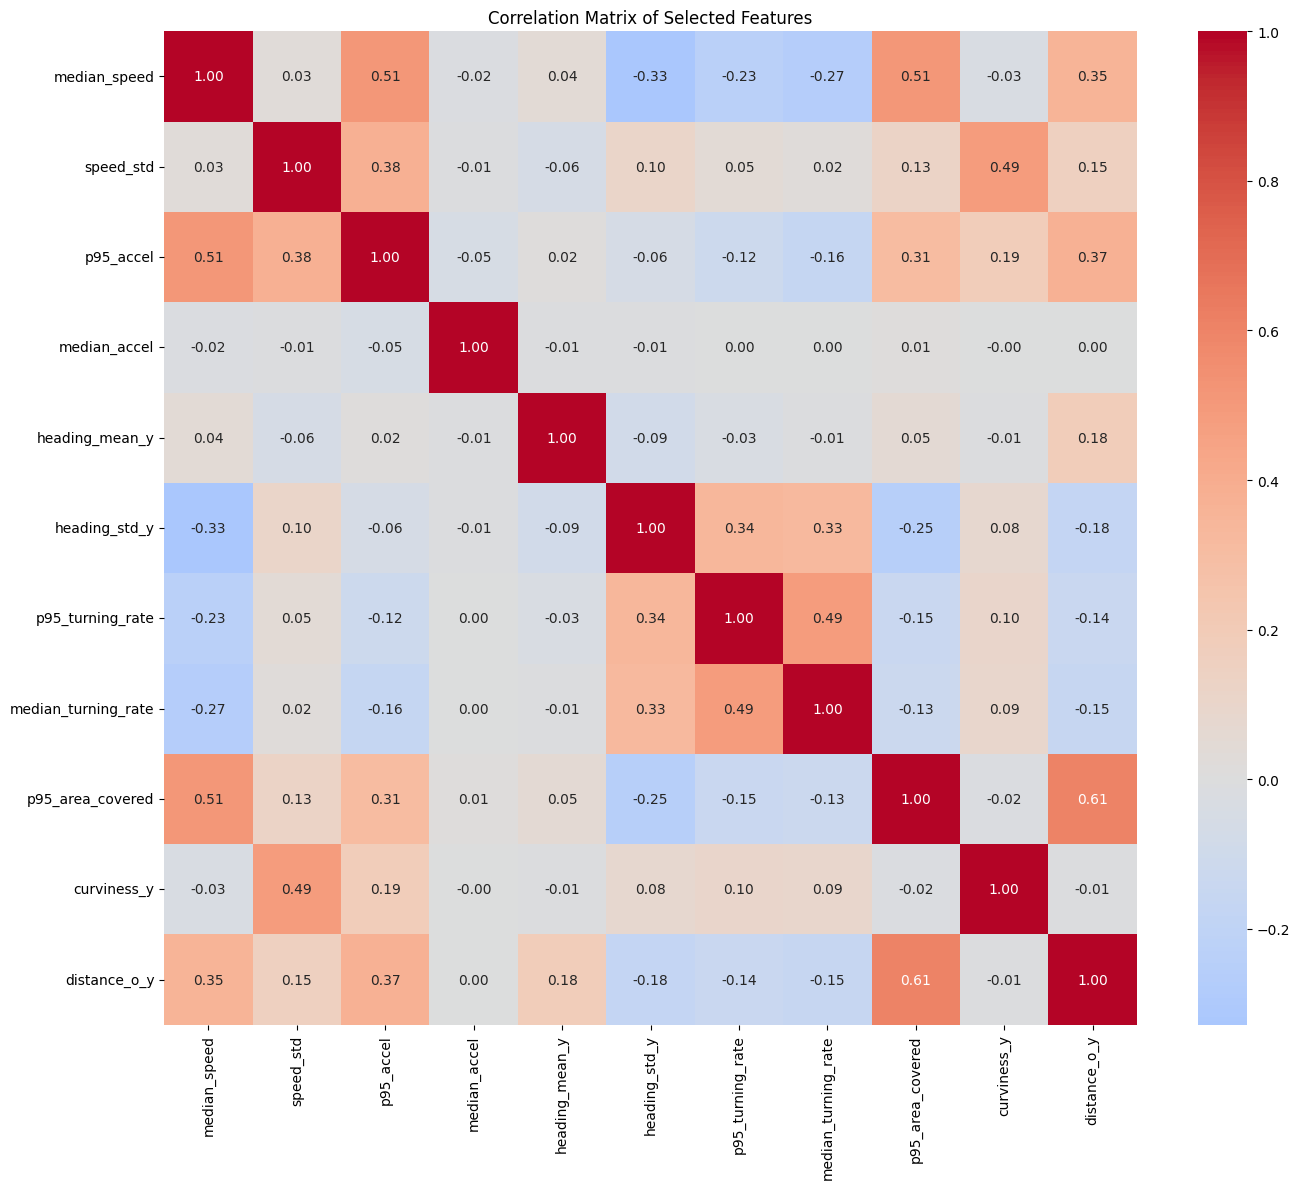

In [162]:
merged_no_disrupted = merged_two[merged_two['disrupted'] == 0]
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = merged_no_disrupted[features_subset].corr()

# Plot using seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()


In [163]:
from utilities import VesselTypeAggregator

aggregator = VesselTypeAggregator()
aggregator.aggregate_vessel_type(merged_two)
merged_two['type_m2_agg'].value_counts()

type_m2_agg
cargo/tanker      6750
passenger_ship    4803
class_b           2783
other             2035
tug/tow           1107
fishing_boat       707
military_ship      641
pleasure_craft     358
Name: count, dtype: int64

In [164]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features and target
X = merged_two[features_subset]
y = merged_two['type_m2_agg']

#Type to number mapping
ship2num, num2ship = {}, {}
num = 0
for vessel in y.unique():
    ship2num[vessel] = num
    num2ship[num] = vessel
    num += 1
y_numeric = y.map(ship2num)

# Train-test split (80:20), stratified sampling by vessel type
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42)

# Define XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if you want probability outputs
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    random_state=42
)

# Hyperparameter tuning (after a few tries)
param_grid = {
    'max_depth': [13],
    'learning_rate': [0.15],
    'n_estimators': [200]
}

# Perform 4-fold cross-validation with grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=4,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)


grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTest Set Accuracy: {:.4f}".format(test_accuracy))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'learning_rate': 0.15, 'max_depth': 13, 'n_estimators': 200}
Best cross-validation accuracy: 0.7865

Test Set Accuracy: 0.7928


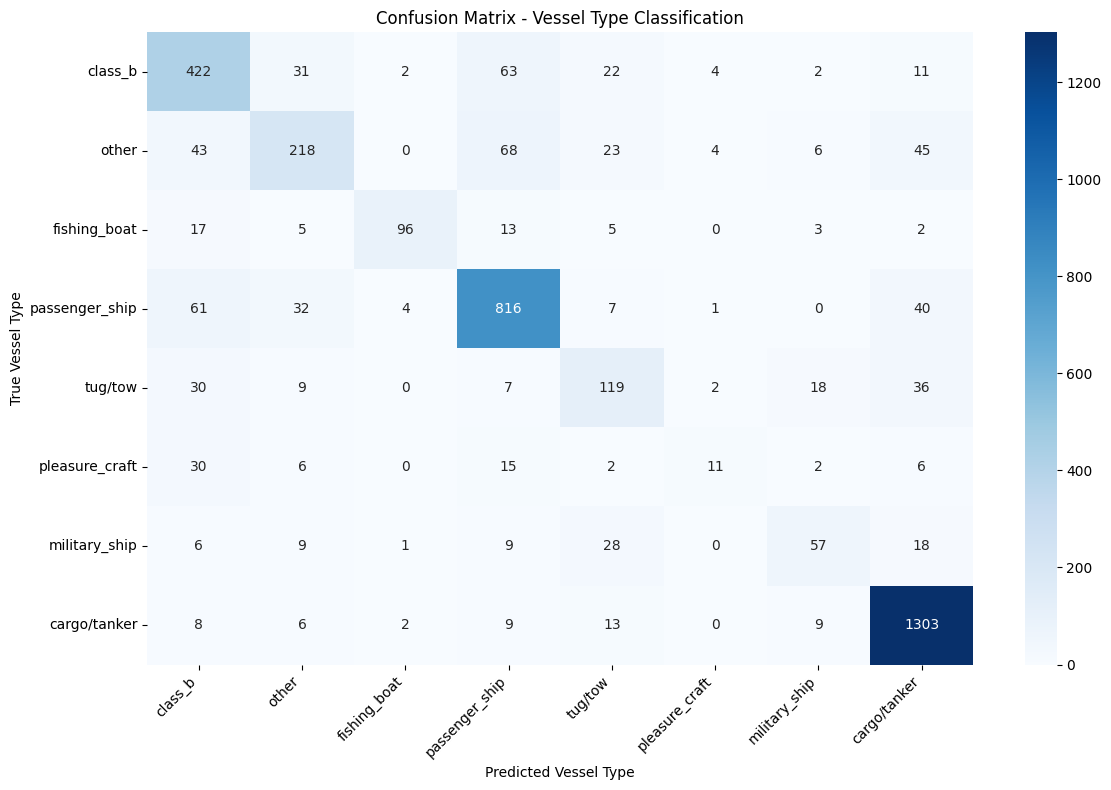

In [165]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure with a larger size
plt.figure(figsize=(12, 8))

# Create heatmap of confusion matrix
sns.heatmap(cm, 
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='Blues',  # Use blue color scheme
            xticklabels=list(ship2num.keys()),  # Use vessel type names for x-axis
            yticklabels=list(ship2num.keys()))  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Vessel Type Classification')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

# Print classification report for detailed metrics
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=list(ship2num.keys())))

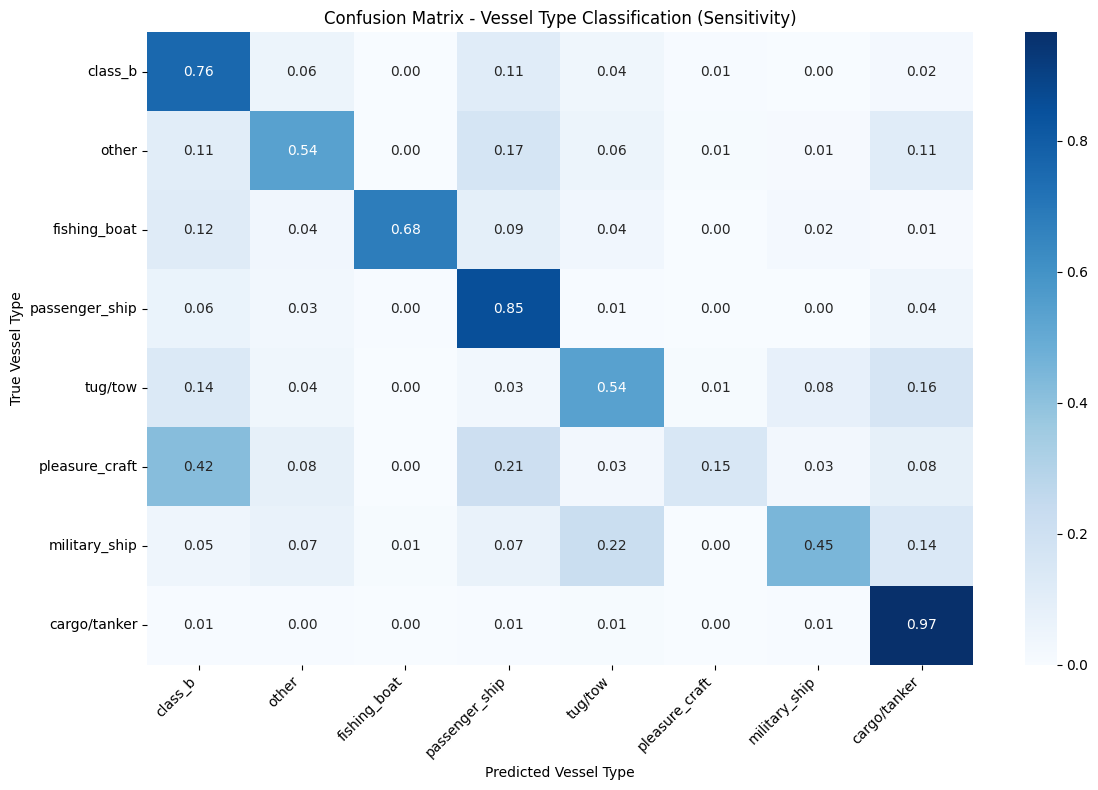

In [166]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (recall) for each class
sensitivity = cm.diagonal() / cm.sum(axis=1)

# Create a figure with a larger size
plt.figure(figsize=(12, 8))

# Create a matrix where each row is normalized by the sum of that row
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# Create heatmap of normalized confusion matrix
sns.heatmap(cm_normalized, 
            annot=True,  # Show numbers in cells
            fmt='.2f',   # Format as percentages
            cmap='Blues',  # Use blue color scheme
            xticklabels=y.unique(),  # Use vessel type names for x-axis
            yticklabels=y.unique())  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Vessel Type Classification (Sensitivity)')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

<Figure size 1000x800 with 0 Axes>

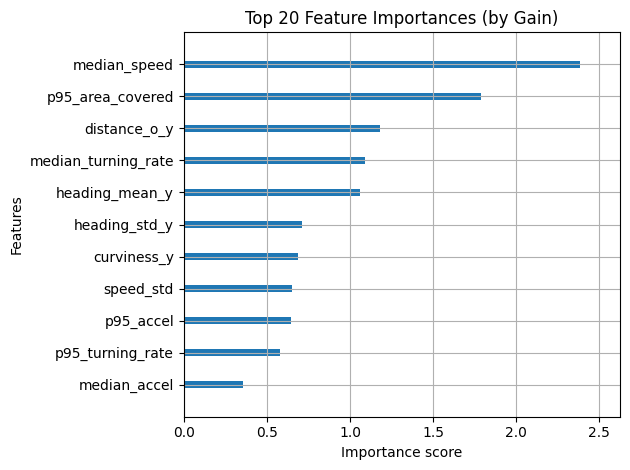

In [167]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, max_num_features=20, importance_type='gain', show_values=False)
plt.title('Top 20 Feature Importances (by Gain)')
plt.tight_layout()
plt.show()
